# Working with particles in halos and subhalos/galaxies

[![Binder](https://mybinder.org/badge_logo.svg)](https://binder.flatironinstitute.org/v2/user/sgenel/CAMELS_PUBLIC?filepath=/Tutorials/particles_subhalos.ipynb)

Here we show four different cases:
- Selecting the particles inside IllustrisTNG halos
- Selecting the particles inside halos of simulations that are not IllustrisTNG
- Selecting the particles inside IllustrisTNG subhalos/galaxies
- Selecting the particles inside subhalos/galaxies from simulatons that are not IllustrisTNG

The reason why the procedure for IllustrisTNG and non-IllustrisTNG simulations is slighty different is because the snapshots of the IllustrisTNG simulations are sorted such as the first particles in the snapshots are the one that belong to the first halo, the next particles in the simulations are the ones that belong to the second halos...etc. For other simulations, this is not the case so we need to read an additional block that contains the IDs of the particles in the halos/subhalos/galaxies. For details on how the data is organized in the IllustrisTNG simulations please check [this](https://www.tng-project.org/data/docs/specifications/#sec1a).

Note that the Nbody counterparts of the IllustrisTNG simulations fall into non-IllustrisTNG simulations.

In [1]:
import numpy as np
import h5py

### Particles inside FoF halos: IllustrisTNG
We first showing how to identify the particles that belong to a given FoF halo in IllustrisTNG

In [2]:
# get the name of the snapshot and its corresponding Subfind halo catalog
f_snapshot = '/home/jovyan/Data/Sims/IllustrisTNG/CV/CV_0/snap_033.hdf5'
f_catalog  = '/home/jovyan/Data/FOF_Subfind/IllustrisTNG/CV/CV_0/fof_subhalo_tab_033.hdf5'

Lets read the halo catalog

In [3]:
f = h5py.File(f_catalog, 'r')
f.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

Lets see what is in the Group block

In [4]:
f['Group'].keys()

<KeysViewHDF5 ['GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']>

Now, lets read the positions, velocities, masses, and lenghts of the halos

In [5]:
pos_h     = f['Group/GroupPos'][:]/1e3   #Mpc/h
vel_h     = f['Group/GroupVel'][:]       #km/s
SFR_h     = f['Group/GroupSFR'][:]       #Msun/yr
mass_h    = f['Group/GroupMass'][:]*1e10 #Msun/h
len_h     = f['Group/GroupLen'][:]       #the total number of particles in the halo (gas+dm+stars+black_holes)
lentype_h = f['Group/GroupLenType'][:]   #the number of particles in a halo by particle type
f.close()

Lets print the position, velocity, mass and length of a given halo

In [6]:
index = 167 #index of the halo
print('position:',pos_h[index],'Mpc/h')
print('velocity:',vel_h[index],'km/s')
print('mass: %.3e Msun/h'%mass_h[index])
print('total length:',len_h[index],'particles')
print('number of particles by type:',lentype_h[index])

position: [ 9.327968  17.098047   3.0652359] Mpc/h
velocity: [-51.31196  -29.259886 -33.310223] km/s
mass: 3.354e+11 Msun/h
total length: 7542 particles
number of particles by type: [2976 4543    0    0   20    3]


Now imagine we want to select the gas particles that belong to this halo. For this, we need to know where the particles start in the list. This can be done as follows:

In [7]:
offset = np.sum(lentype_h[:index], axis=0) #this is the sum of the lengths of all FoF halos previous to the one we consider

We can now read the particles in the snapshot and identify the ones in this halo as

In [8]:
f = h5py.File(f_snapshot, 'r')
print(f.keys())

<KeysViewHDF5 ['Header', 'PartType0', 'PartType1', 'PartType4', 'PartType5']>


Lets see what gas properties do we have

In [9]:
print(f['PartType0'].keys())

<KeysViewHDF5 ['Coordinates', 'Density', 'ElectronAbundance', 'EnergyDissipation', 'GFM_AGNRadiation', 'GFM_CoolingRate', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_WindDMVelDisp', 'GFM_WindHostHaloMass', 'InternalEnergy', 'Machnumber', 'MagneticField', 'MagneticFieldDivergence', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'StarFormationRate', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>


Now, lets read the positions, velocities, and star formation rates of the gas particles in the above halo

In [10]:
# the gas particles of this halos will start at offset[0] and will contain lentype_h[0] particles
start = offset[0]
end   = offset[0]+lentype_h[index,0]
pos_gas = f['PartType0/Coordinates'][start:end]/1e3   #Mpc/h
vel_gas = f['PartType0/Velocities'][start:end]        #km/s
sfr_gas = f['PartType0/StarFormationRate'][start:end] #Msun/yr
f.close()

#pos_dm = f['PartType1/Coordinates'][:]/1e3   #Mpc/h
#vel_dm = f['PartType1/Velocities'][:]        #km/s

Lets check if the positions of the particles are around the center of the halo

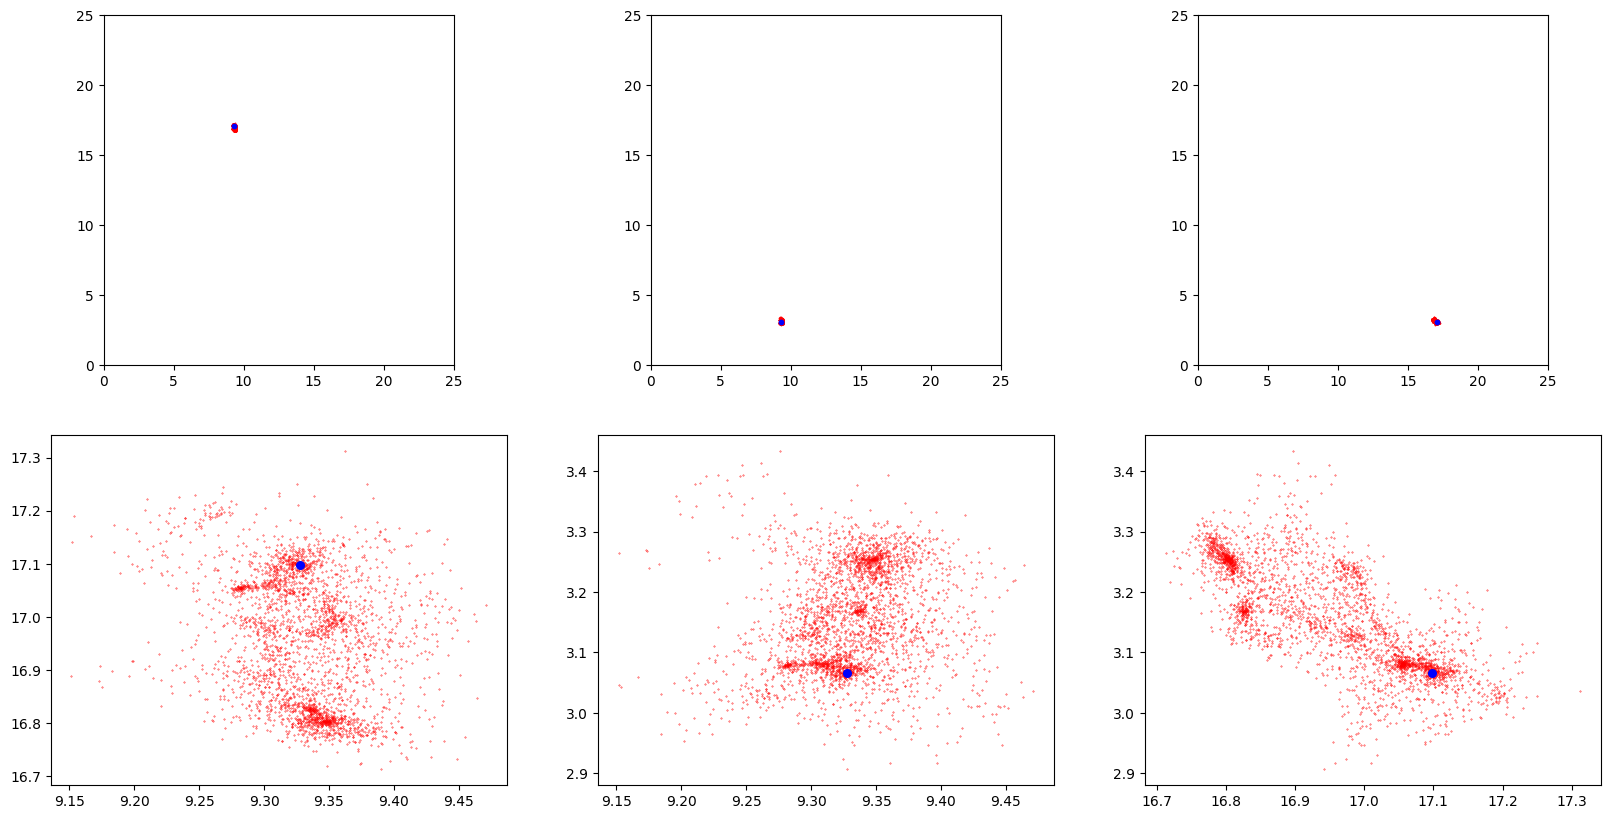

In [11]:
import matplotlib.pyplot as plt
from pylab import *
fig = figure(figsize=(20,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
for ax in [ax1,ax2,ax3]:
    ax.set_aspect('equal')
    ax.set_xlim([0,25])
    ax.set_ylim([0,25])
ax1.scatter(pos_gas[:,0], pos_gas[:,1], s=0.1,c='r')
ax2.scatter(pos_gas[:,0], pos_gas[:,2], s=0.1,c='r')
ax3.scatter(pos_gas[:,1], pos_gas[:,2], s=0.1,c='r')
ax1.scatter(pos_h[index,0], pos_h[index,1], s=10, c='b')
ax2.scatter(pos_h[index,0], pos_h[index,2], s=10, c='b')
ax3.scatter(pos_h[index,1], pos_h[index,2], s=10, c='b')
# now make a zoom-in
ax4.scatter(pos_gas[:,0], pos_gas[:,1], s=0.1,c='r')
ax5.scatter(pos_gas[:,0], pos_gas[:,2], s=0.1,c='r')
ax6.scatter(pos_gas[:,1], pos_gas[:,2], s=0.1,c='r')
ax4.scatter(pos_h[index,0], pos_h[index,1], s=30, c='b')
ax5.scatter(pos_h[index,0], pos_h[index,2], s=30, c='b')
ax6.scatter(pos_h[index,1], pos_h[index,2], s=30, c='b')
plt.show()

Lets check if the star-formation rate of this group is equal to the star-formation rate of the gas particles on it

In [12]:
SFR1 = np.sum(sfr_gas)
print('SFR from the gas particles = %.3e Msun/yr'%SFR1)
print('SFR of the FoF group = %.3e Msun/yr'%SFR_h[index])

SFR from the gas particles = 5.332e-02 Msun/yr
SFR of the FoF group = 5.332e-02 Msun/yr


In a similar way, we can read the properties of the dark matter particles in a FoF halo

In [13]:
# the dark matter particles of this halos will start at offset[1] and will contain lentype_h[1] particles
f = h5py.File(f_snapshot, 'r')
start = offset[1]
end   = offset[1]+lentype_h[index,1]
pos_dm = f['PartType1/Coordinates'][start:end]/1e3   #Mpc/h
vel_dm = f['PartType1/Velocities'][start:end]        #km/s
f.close()

# lets print the positions of the dark matter particles to see that they are around the halo center
print(pos_dm)

[[ 9.327825  17.098303   3.0644984]
 [ 9.32777   17.098856   3.0653036]
 [ 9.328103  17.097187   3.065979 ]
 ...
 [ 9.272596  16.833157   3.1447148]
 [ 9.27645   16.907875   3.1141644]
 [ 9.411737  16.957142   3.074211 ]]


### Particles inside FoF halos: SIMBA, Astrid, Magneticum
We now show to read the particles inside halos for simulations that are not IllustrisTNG. 

In [14]:
# get the name of the snapshot and its corresponding Subfind halo catalog
f_snapshot = '/home/jovyan/Data/Sims/SIMBA/1P/1P_2_4/snap_033.hdf5'
f_catalog  = '/home/jovyan/Data/FOF_Subfind/SIMBA/1P/1P_2_4/fof_subhalo_tab_033.hdf5'

Lets read the halo catalog

In [15]:
f = h5py.File(f_catalog, 'r')
print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


Lets see what is in the Group and IDs blocks

In [16]:
print(f['Group'].keys())
print(f['IDs'].keys())

<KeysViewHDF5 ['GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']>
<KeysViewHDF5 ['ID']>


Now, lets read the positions, velocities, masses, and lenghts of the halos. For simulations other than IllustrisTNG, we can also also read a block with the particles IDs

In [17]:
pos_h      = f['Group/GroupPos'][:]/1e3   #Mpc/h
vel_h      = f['Group/GroupVel'][:]       #km/s
SFR_h      = f['Group/GroupSFR'][:]       #Msun/yr
mass_h     = f['Group/GroupMass'][:]*1e10 #Msun/h
len_h      = f['Group/GroupLen'][:]       #the total number of particles in the halo (gas+dm+stars+black_holes)
lentype_h  = f['Group/GroupLenType'][:]   #the number of particles in a halo by particle type
IDs_h      = f['IDs']['ID'][:]
f.close()

Lets take a look at the IDs of the particles in the halos. Lets seen that it contains as many IDs as particles in halos:

In [18]:
print('The number of IDs is:',IDs_h.shape)
print('The total number of particles in all halos is: %d'%np.sum(len_h))

The number of IDs is: (14546093,)
The total number of particles in all halos is: 14546093


Lets choose a given halo and print its position, velocity, mass, and length

In [19]:
index = 351 #index of the halo
print('position:',pos_h[index],'Mpc/h')
print('velocity:',vel_h[index],'km/s')
print('mass: %.3e Msun/h'%mass_h[index])
print('star-formation rate: %.3e'%SFR_h[index])
print('total length:',len_h[index],'particles')
print('number of particles by type:',lentype_h[index])

position: [22.522245 14.857593  4.033678] Mpc/h
velocity: [ 76.06228  -34.665913 -98.167984] km/s
mass: 1.575e+11 Msun/h
star-formation rate: 1.196e+00
total length: 3440 particles
number of particles by type: [1036 2183    0    0  221    0]


We first need to get the IDs of the particles belonging to this halo with

In [20]:
start = np.sum(len_h[:index])
end   = start+len_h[index]
indexes_h = IDs_h[start:end]
print('This halo contains %d particles'%indexes_h.shape[0])

This halo contains 3440 particles


indexes represent the IDs of the particles belonging to that halo. We can now read the property we want from the simulation and use those IDs to identify the particles in that halo

In [21]:
f = h5py.File(f_snapshot, 'r')
print(f.keys())
print(f['PartType0'].keys(),'\n')
print(f['PartType1'].keys(),'\n')
print(f['PartType4'].keys(),'\n')
print(f['PartType5'].keys(),'\n')

<KeysViewHDF5 ['Header', 'PartType0', 'PartType1', 'PartType4', 'PartType5']>
<KeysViewHDF5 ['AGS-Softening', 'Coordinates', 'DelayTime', 'Density', 'Dust_Masses', 'Dust_Metallicity', 'ElectronAbundance', 'FractionH2', 'GrackleHI', 'GrackleHII', 'GrackleHM', 'GrackleHeI', 'GrackleHeII', 'GrackleHeIII', 'HaloID', 'ID_Generations', 'InternalEnergy', 'Masses', 'Metallicity', 'NWindLaunches', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'Sigma', 'SmoothingLength', 'StarFormationRate', 'Velocities']> 

<KeysViewHDF5 ['AGS-Softening', 'Coordinates', 'HaloID', 'ID_Generations', 'Masses', 'ParticleIDs', 'Potential', 'Velocities']> 

<KeysViewHDF5 ['AGS-Softening', 'Coordinates', 'Dust_Masses', 'Dust_Metallicity', 'HaloID', 'ID_Generations', 'Masses', 'Metallicity', 'ParticleIDs', 'Potential', 'StellarFormationTime', 'Velocities']> 

<KeysViewHDF5 ['AGS-Softening', 'BH_AccretionLength', 'BH_Mass', 'BH_Mass_AlphaDisk', 'BH_Mdot', 'BH_NProgs', 'Coordinates', 'HaloID', 'ID_Generations',

Lets read the header of this simulation and the total number of particles on it

In [22]:
BoxSize      = f['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = f['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = f['Header'].attrs[u'Time']           #scale factor
h            = f['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Masses       = f['Header'].attrs[u'MassTable']*1e10 #masses of the particles in Msun/h
Np           = f['Header'].attrs[u'NumPart_Total']  #total number of particles for specie
Omega_m      = f['Header'].attrs[u'Omega0']         #Omega_matter
Omega_L      = f['Header'].attrs[u'OmegaLambda']    #Omega_baryon
print('Total number of particles in the snapshot per type',Np)

Total number of particles in the snapshot per type [15783459 16777216        0        0   989418      976]


Lets read the positions and velocities of the particles belonging to this halos

In [23]:
pos_gas   = f['PartType0/Coordinates'][:]/1e3   #Mpc/h
pos_dm    = f['PartType1/Coordinates'][:]/1e3   #Mpc/h
pos_stars = f['PartType4/Coordinates'][:]/1e3   #Mpc/h
pos_bh    = f['PartType5/Coordinates'][:]/1e3   #Mpc/h

vel_gas   = f['PartType0/Velocities'][:]        #km/s
vel_dm    = f['PartType1/Velocities'][:]        #km/s
vel_stars = f['PartType4/Velocities'][:]        #km/s
vel_bh    = f['PartType5/Velocities'][:]        #km/s

IDs_gas   = f['PartType0/ParticleIDs'][:]
IDs_dm    = f['PartType1/ParticleIDs'][:]
IDs_stars = f['PartType4/ParticleIDs'][:]
IDs_bh    = f['PartType5/ParticleIDs'][:]

f.close()

Now we want to match the IDs of the particles belonging the halo that we have stored in the indexes variable with the IDs of the different particle types from the snapshot. Lets first do this for the gas particles

In [24]:
# This routine will find the common IDs and also return their location in each array
common_indexes, indexes1, indexes2 = np.intersect1d(IDs_gas, indexes_h, assume_unique=False, return_indices=True)
pos_gas_halo = pos_gas[indexes1]
vel_gas_halo = vel_gas[indexes1]

Lets make a plot with the positions of the particles to see where they are

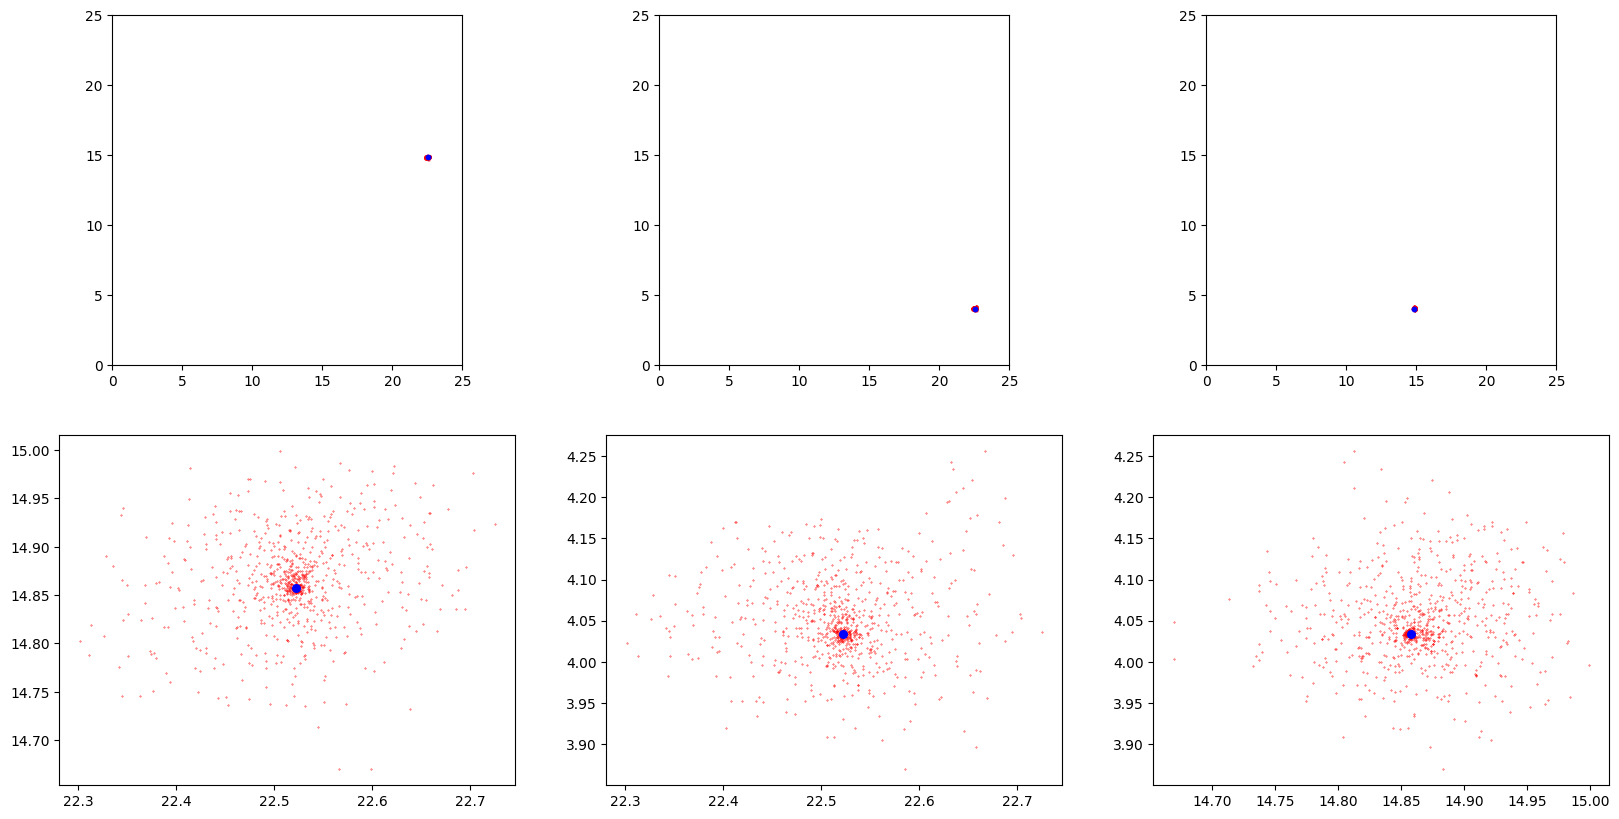

In [25]:
import matplotlib.pyplot as plt
from pylab import *
fig = figure(figsize=(20,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
for ax in [ax1,ax2,ax3]:
    ax.set_aspect('equal')
    ax.set_xlim([0,25])
    ax.set_ylim([0,25])
ax1.scatter(pos_gas_halo[:,0], pos_gas_halo[:,1], s=0.1,c='r')
ax2.scatter(pos_gas_halo[:,0], pos_gas_halo[:,2], s=0.1,c='r')
ax3.scatter(pos_gas_halo[:,1], pos_gas_halo[:,2], s=0.1,c='r')
ax1.scatter(pos_h[index,0], pos_h[index,1], s=10, c='b')
ax2.scatter(pos_h[index,0], pos_h[index,2], s=10, c='b')
ax3.scatter(pos_h[index,1], pos_h[index,2], s=10, c='b')
# now make a zoom-in
ax4.scatter(pos_gas_halo[:,0], pos_gas_halo[:,1], s=0.1,c='r')
ax5.scatter(pos_gas_halo[:,0], pos_gas_halo[:,2], s=0.1,c='r')
ax6.scatter(pos_gas_halo[:,1], pos_gas_halo[:,2], s=0.1,c='r')
ax4.scatter(pos_h[index,0], pos_h[index,1], s=30, c='b')
ax5.scatter(pos_h[index,0], pos_h[index,2], s=30, c='b')
ax6.scatter(pos_h[index,1], pos_h[index,2], s=30, c='b')
plt.show()

Lets check that the star-formation rate of this halo is equal to the star-formation rate of the gas particles on it

In [26]:
# lets read the SFR of the gas particles in the snapshot
f = h5py.File(f_snapshot, 'r')
sfr_gas = f['PartType0/StarFormationRate'][:] #Msun/yr
IDs_gas = f['PartType0/ParticleIDs'][:]
f.close()

common_indexes, indexes1, indexes2 = np.intersect1d(IDs_gas, indexes_h, assume_unique=False, return_indices=True)
SFR = sfr_gas[indexes1]

# lets check the total star-formation rates
print('Total star-formation rate from the gas particles in the halo: %.3e'%np.sum(SFR))
print('Total star-formation rate from the halo catalog: %.3e'%SFR_h[index])

Total star-formation rate from the gas particles in the halo: 1.196e+00
Total star-formation rate from the halo catalog: 1.196e+00


### Particles in a subhalo/galaxy: IllustrisTNG

In [27]:
# get the name of the snapshot and its corresponding Subfind catalog
f_snapshot = '/home/jovyan/Data/Sims/IllustrisTNG/LH/LH_50/snap_033.hdf5'
f_catalog  = '/home/jovyan/Data/FOF_Subfind/IllustrisTNG/LH/LH_50/fof_subhalo_tab_033.hdf5'

Lets start reading the halo/subhalo catalog

In [28]:
f = h5py.File(f_catalog, 'r')
print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


We need to read data from both the Group and the Subhalo blocks

In [29]:
print(f['Group'].keys(),'\n')
print(f['Subhalo'].keys())

<KeysViewHDF5 ['GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']> 

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'Subhal

In [30]:
# lets read the length of the FoF groups and the number of subhalos they contain
lentype_h = f['Group/GroupLenType'][:]
Nsub_h = f['Group/GroupNsubs'][:]

# for the subhalos lets read their position, mass, velocity, and SFR
pos_sh     = f['Subhalo/SubhaloPos'][:]/1e3        #Mpc/h
vel_sh     = f['Subhalo/SubhaloVel'][:]            #km/s
mass_sh    = f['Subhalo/SubhaloMassType'][:]*1e10  #Msun/h
SFR_sh     = f['Subhalo/SubhaloSFR'][:]            #Msun/yr
lentype_sh = f['Subhalo/SubhaloLenType'][:]
index_h_sh = f['Subhalo/SubhaloGrNr']

Now lets take a given subhalo and prints its properties

In [31]:
index_sh = 972
print('position:',pos_sh[index_sh],'Mpc/h')
print('velocity:',vel_sh[index_sh],'km/s')
print('mass:',mass_sh[index_sh],'Msun/h')
print('total length:',len_h[index_sh],'particles')
print('number of particles by type:',lentype_sh[index_sh])

position: [22.246033  16.84598    3.4119482] Mpc/h
velocity: [ 582.90076   -35.248653 -111.824135] km/s
mass: [4.0012946e+09 6.6489463e+10 0.0000000e+00 0.0000000e+00 8.6655034e+08
 1.8247212e+07] Msun/h
total length: 878 particles
number of particles by type: [265 814   0   0  89   1]


First, we need to know which halo this subhalo/galaxy belongs to, and we can get that with

In [32]:
index_h = index_h_sh[index_sh] #index of the halos where this subhalo belongs to
print('This subhalo belongs to group %d'%index_h)

This subhalo belongs to group 5


Now we need to know how many subhalos/galaxies are before this one in the catalog. For that, lets sum all the subhalos in the halos that are before the halo this subhalo belong to

In [33]:
Nsub_prev_groups = np.sum(Nsub_h[:index_h]) #This is the number of subhalos that the preceeding halos
print('The first %d halos contain %d subhalos'%(index_h,Nsub_prev_groups))

# The number of subhalos that preceed our subhalo in the halo it belongs to is
preceeding_subhalos_in_halo = index_sh - Nsub_prev_groups
print('There are %d subhalos that preceed our subhalo in the halo it belongs to'%preceeding_subhalos_in_halo)

The first 5 halos contain 970 subhalos
There are 2 subhalos that preceed our subhalo in the halo it belongs to


Now we can finally compute the start and end of the indexes of the particles

In [34]:
start = np.sum(lentype_h[:index_h],axis=0) + np.sum(lentype_sh[Nsub_prev_groups:index_sh],axis=0)
end = start + lentype_sh[index_sh]
print(start)
print(end)

[1237429 2179886       0       0  210331     118]
[1237694 2180700       0       0  210420     119]


Now, lets read the positions and velocities of the dark matter of this subhalo/galaxy

In [35]:
f = h5py.File(f_snapshot,'r')
pos_dm = f['PartType1/Coordinates'][start[1]:end[1]]/1e3 #Mpc/h
vel_dm = f['PartType1/Velocities'][start[1]:end[1]]      #km/s
f.close()

Lets plot the positions of the dark matter particles and also the position of the subhalo center

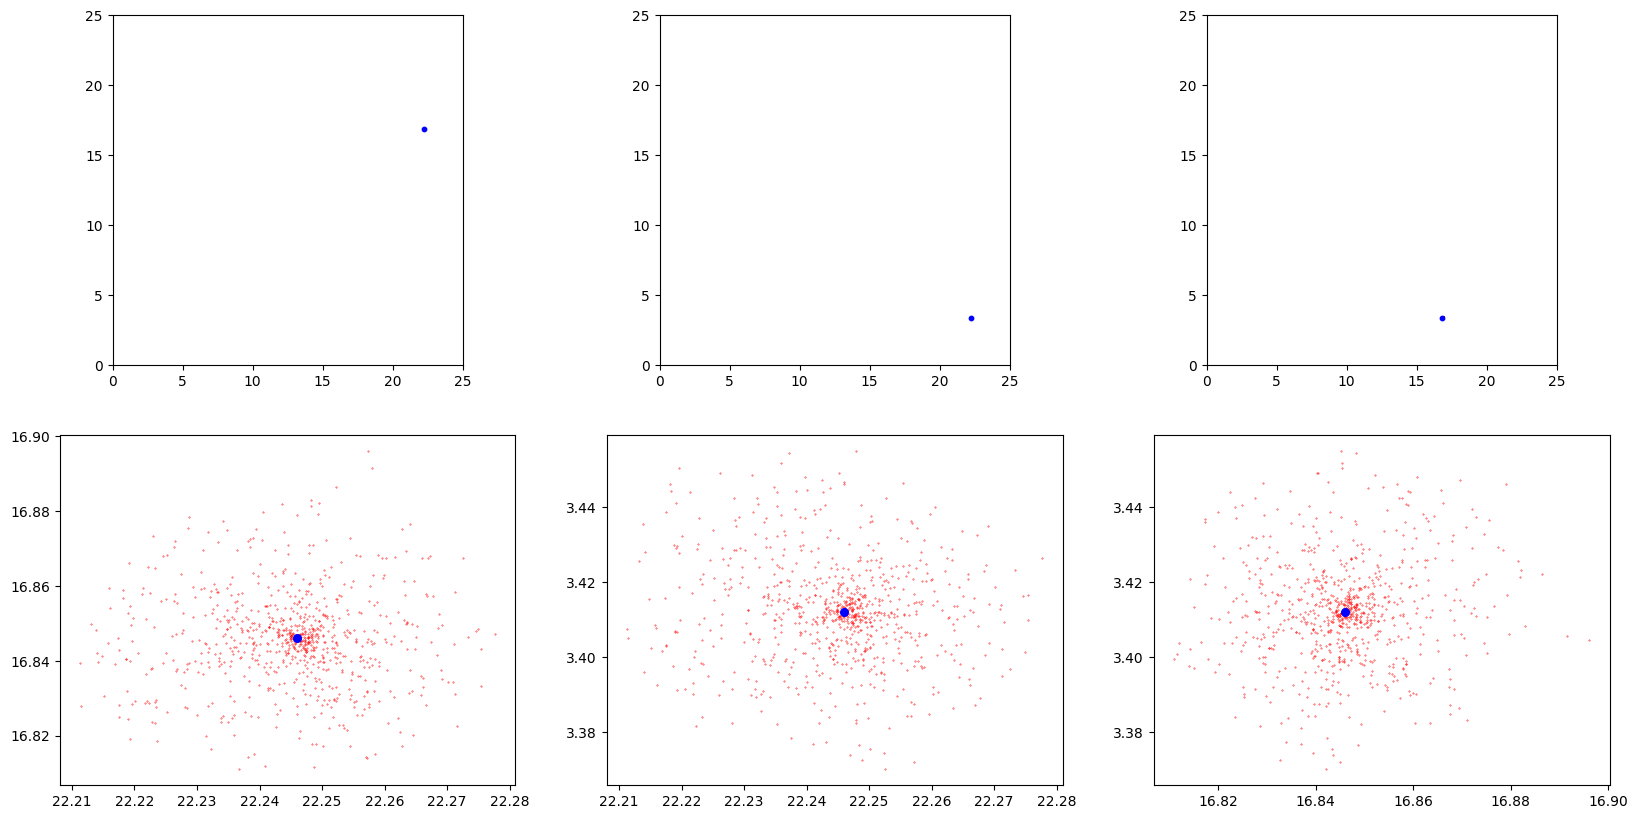

In [36]:
import matplotlib.pyplot as plt
from pylab import *
fig = figure(figsize=(20,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
for ax in [ax1,ax2,ax3]:
    ax.set_aspect('equal')
    ax.set_xlim([0,25])
    ax.set_ylim([0,25])
ax1.scatter(pos_dm[:,0], pos_dm[:,1], s=0.1,c='r')
ax2.scatter(pos_dm[:,0], pos_dm[:,2], s=0.1,c='r')
ax3.scatter(pos_dm[:,1], pos_dm[:,2], s=0.1,c='r')
ax1.scatter(pos_sh[index_sh,0], pos_sh[index_sh,1], s=10, c='b')
ax2.scatter(pos_sh[index_sh,0], pos_sh[index_sh,2], s=10, c='b')
ax3.scatter(pos_sh[index_sh,1], pos_sh[index_sh,2], s=10, c='b')
# now make a zoom-in
ax4.scatter(pos_dm[:,0], pos_dm[:,1], s=0.1,c='r')
ax5.scatter(pos_dm[:,0], pos_dm[:,2], s=0.1,c='r')
ax6.scatter(pos_dm[:,1], pos_dm[:,2], s=0.1,c='r')
ax4.scatter(pos_sh[index_sh,0], pos_sh[index_sh,1], s=30, c='b')
ax5.scatter(pos_sh[index_sh,0], pos_sh[index_sh,2], s=30, c='b')
ax6.scatter(pos_sh[index_sh,1], pos_sh[index_sh,2], s=30, c='b')
plt.show()

Lets check that the stellar mass of this subhalo is equal to the sum of the masses of its stars

In [37]:
print('This subhalo has a stellar mass of %.3e Msun/h'%mass_sh[index_sh,4])

# now select the masses of the stars belonging to this subhalo/galaxy
f = h5py.File(f_snapshot,'r')
masses = f['PartType4/Masses'][start[4]:end[4]]*1e10 #Msun/h
f.close()
print('The sum of the masses of the stars of this subhalo is %.3e Msun/h'%np.sum(masses))

This subhalo has a stellar mass of 8.666e+08 Msun/h
The sum of the masses of the stars of this subhalo is 8.666e+08 Msun/h


In general, any field contained in the snapshot, can be read for the particles that belong to this subhalo as
field = f['PartTypeX/property'][start[X]:end[X]]

### Particles in a subhalo/galaxy: SIMBA, Astrid, Magneticum
We now show to read the particles inside subhalos/galaxies for simulations that are not IllustrisTNG. 

In [38]:
# get the name of the snapshot and its corresponding Subfind catalog
f_snapshot = '/home/jovyan/Data/Sims/Astrid/LH/LH_401/snap_090.hdf5'
f_catalog  = '/home/jovyan/Data/FOF_Subfind/Astrid/LH/LH_401/fof_subhalo_tab_090.hdf5'

Lets start reading the halo/subhalo catalog

In [39]:
f = h5py.File(f_catalog, 'r')
print(f.keys())
print(f['IDs'].keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>
<KeysViewHDF5 ['ID']>


We need to read data from both the Group and the Subhalo blocks

In [40]:
print(f['Group'].keys(),'\n')
print(f['Subhalo'].keys(),'\n')
print(f['IDs'].keys())

<KeysViewHDF5 ['GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200']> 

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'Subhal

In [41]:
# lets read the length of the FoF groups and the number of subhalos they contain
len_h  = f['Group/GroupLen'][:]
Nsub_h = f['Group/GroupNsubs'][:]

# for the subhalos lets read their position, mass, velocity, and SFR
pos_sh     = f['Subhalo/SubhaloPos'][:]/1e3        #Mpc/h
vel_sh     = f['Subhalo/SubhaloVel'][:]            #km/s
mass_sh    = f['Subhalo/SubhaloMassType'][:]*1e10  #Msun/h
SFR_sh     = f['Subhalo/SubhaloSFR'][:]            #Msun/yr
len_sh     = f['Subhalo/SubhaloLen'][:]
lentype_sh = f['Subhalo/SubhaloLenType'][:]
index_h_sh = f['Subhalo/SubhaloGrNr']

# lets also read the IDs block
IDs_sh = f['IDs/ID'][:]

Now lets take a given subhalo and print its properties

In [42]:
index_sh = 589
print('position:',pos_sh[index_sh],'Mpc/h')
print('velocity:',vel_sh[index_sh],'km/s')
print('mass:',mass_sh[index_sh],'Msun/h')
print('total length:',len_sh[index_sh],'particles')
print('number of particles by type:',lentype_sh[index_sh])

position: [ 3.00393  14.963539 22.125805] Mpc/h
velocity: [-98.59593  -42.708527 332.98932 ] km/s
mass: [1.68489472e+08 1.12988455e+11 0.00000000e+00 0.00000000e+00
 3.46133024e+08 0.00000000e+00] Msun/h
total length: 1478 particles
number of particles by type: [  14 1170    0    0  294    0]


First, we need to know which halo this subhalo/galaxy belongs to, and we can get that with

In [43]:
index_h = index_h_sh[index_sh] #index of the halos where this subhalo belongs to
print('This subhalo belongs to group %d'%index_h)

This subhalo belongs to group 3


Now we need to know how many subhalos/galaxies are before this one in the catalog. For that, lets sum all the subhalos in the halos that are before the halo this subhalo belong to

In [44]:
Nsub_prev_groups = np.sum(Nsub_h[:index_h]) #This is the number of subhalos that the preceeding halos
print('The first %d halos contain %d subhalos'%(index_h,Nsub_prev_groups))

# The number of subhalos that preceed our subhalo in the halo it belongs to is
preceeding_subhalos_in_halo = index_sh - Nsub_prev_groups
print('There are %d subhalos that preceed our subhalo in the halo it belongs to'%preceeding_subhalos_in_halo)

The first 3 halos contain 584 subhalos
There are 5 subhalos that preceed our subhalo in the halo it belongs to


Now we can finally compute the start and end of the indexes of the particles

In [45]:
start = np.sum(len_h[:index_h]) + np.sum(len_sh[Nsub_prev_groups:index_sh])
end = start + len_sh[index_sh]
print(start)
print(end)

2925850
2927328


We can get the IDs of the particles that belong to this subhalo/galaxy as this

In [46]:
indexes = IDs_sh[start:end]
print(indexes)

[         20338487          20367737          20409329 ...
 72057594058295854 72057594058300274 72057594058283564]


As can be seen, differently to the SIMBA simulations, the IDs of Astrid can be very large. For dealing with this we will need to explictly match IDs. Lets now read the snapshot and some properties of it

In [47]:
f = h5py.File(f_snapshot, 'r')
print(f.keys())
print(f['PartType0'].keys(),'\n')
print(f['PartType1'].keys(),'\n')
print(f['PartType4'].keys(),'\n')
print(f['PartType5'].keys(),'\n')

<KeysViewHDF5 ['Header', 'PartType0', 'PartType1', 'PartType4', 'PartType5']>
<KeysViewHDF5 ['Coordinates', 'Density', 'ElectronAbundance', 'GFM_Metallicity', 'GFM_Metals', 'InternalEnergy', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'SmoothingLength', 'StarFormationRate', 'Velocities']> 

<KeysViewHDF5 ['Coordinates', 'Masses', 'ParticleIDs', 'Velocities']> 

<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'GFM_Metals', 'GFM_StellarFormationTime', 'Masses', 'ParticleIDs', 'Velocities']> 

<KeysViewHDF5 ['BH_Density', 'BH_Mass', 'BH_Mdot', 'Coordinates', 'GFM_StellarFormationTime', 'Masses', 'ParticleIDs', 'SmoothingLength', 'Velocities']> 



Lets read the positions and masses of the gas, dark matter, and stars in the snapshot

In [48]:
pos_gas    = f['PartType0/Coordinates'][:]/1e3   #Mpc/h
pos_dm     = f['PartType1/Coordinates'][:]/1e3   #Mpc/h
pos_stars  = f['PartType4/Coordinates'][:]/1e3   #Mpc/h
mass_gas   = f['PartType0/Masses'][:]*1e10       #Msun/h
mass_dm    = f['PartType1/Masses'][:]*1e10       #Msun/h
mass_stars = f['PartType4/Masses'][:]*1e10       #Msun/h
IDs_gas    = f['PartType0/ParticleIDs'][:]
IDs_dm     = f['PartType1/ParticleIDs'][:]
IDs_stars  = f['PartType4/ParticleIDs'][:]
f.close()

Now lets see the locations where the IDs of the particles belonging to the subhalo match those of the dark matter particles in the snapshot

In [49]:
common_indexes, indexes1, indexes2 = np.intersect1d(IDs_dm, indexes, assume_unique=False, return_indices=True)
print('The IDs that are in both the gas and all particles in the subhalo are', common_indexes)
print('The indexes of the common IDs in the gas array', indexes1)

The IDs that are in both the gas and all particles in the subhalo are [1570675 2009055 2017184 ... 3632115 4064806 4122391]
The indexes of the common IDs in the gas array [15181907 15179506 15179189 ... 15179209 15179808 15181651]


Lets plot the positions of the gas particles belonging to this subhalo/galaxy together with the subhalo center

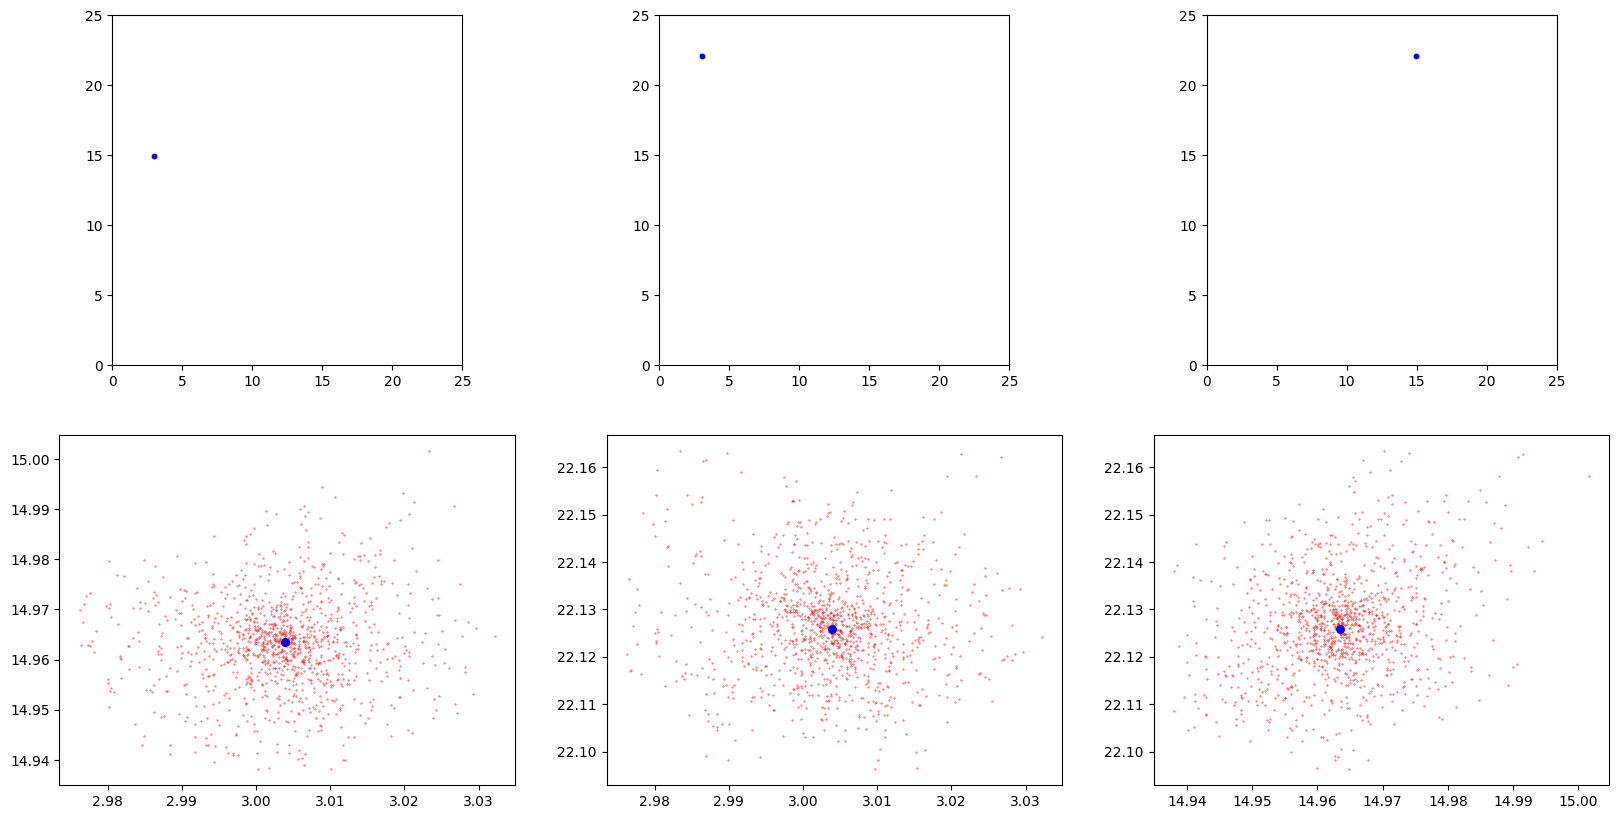

In [50]:
pos_dm_subhalo = pos_dm[indexes1]

import matplotlib.pyplot as plt
from pylab import *
fig = figure(figsize=(20,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
for ax in [ax1,ax2,ax3]:
    ax.set_aspect('equal')
    ax.set_xlim([0,25])
    ax.set_ylim([0,25])
ax1.scatter(pos_dm_subhalo[:,0], pos_dm_subhalo[:,1], s=0.1,c='r')
ax2.scatter(pos_dm_subhalo[:,0], pos_dm_subhalo[:,2], s=0.1,c='r')
ax3.scatter(pos_dm_subhalo[:,1], pos_dm_subhalo[:,2], s=0.1,c='r')
ax1.scatter(pos_sh[index_sh,0], pos_sh[index_sh,1], s=10, c='b')
ax2.scatter(pos_sh[index_sh,0], pos_sh[index_sh,2], s=10, c='b')
ax3.scatter(pos_sh[index_sh,1], pos_sh[index_sh,2], s=10, c='b')
# now make a zoom-in
ax4.scatter(pos_dm_subhalo[:,0], pos_dm_subhalo[:,1], s=0.1,c='r')
ax5.scatter(pos_dm_subhalo[:,0], pos_dm_subhalo[:,2], s=0.1,c='r')
ax6.scatter(pos_dm_subhalo[:,1], pos_dm_subhalo[:,2], s=0.1,c='r')
ax4.scatter(pos_sh[index_sh,0], pos_sh[index_sh,1], s=30, c='b')
ax5.scatter(pos_sh[index_sh,0], pos_sh[index_sh,2], s=30, c='b')
ax6.scatter(pos_sh[index_sh,1], pos_sh[index_sh,2], s=30, c='b')
plt.show()

Lets now check that the stellar mass of this galaxy is the same as the sum of the masses of its stars

In [51]:
common_indexes, indexes1, indexes2 = np.intersect1d(IDs_stars, indexes, assume_unique=False, return_indices=True)
SM = mass_stars[indexes1]
print('Sum of the masses of the stars of this galaxy: %.3e'%np.sum(SM))
print('Stellar mass of the galaxy: %.3e'%mass_sh[index_sh,4])

Sum of the masses of the stars of this galaxy: 3.461e+08
Stellar mass of the galaxy: 3.461e+08


In general, given a property that wants to be known for the particles in a subhalo, one needs to read it together with the particle ids of that type. E.g. to read the metallicities of the gas particles in a subhalo/galaxy, one needs to read all gas particle metallicities and their IDs. Then, matching IDs between the particles in the halo and the read particles can be done using the above intersect1d routine. Finally, one can just take the value of the considered property in the particles belonging to the subhalo as:

property = property_read_from_snapshot[indexes1]